In [6]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

In [8]:
base_folder = Path(f"/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/") 

adata_file = base_folder / "data" / "cell_segmentation" / "concatenated" / "combined_adata.h5ad"
laina_results_dir = base_folder / "results" / "LIANA"

ST_sample = sc.read_h5ad(adata_file)
PTEN_list = ['35_LGIRT', '33_LGIRT', '37_CRRT', '31_RT', '34_LGIRT', '36_CRRT', '38_CRRT', '32_RT']
ST_sample = ST_sample[ST_sample.obs["mouse"].isin(PTEN_list)].copy()

In [9]:
# Expect: ST_sample is your AnnData with nuclei (StarDist) in .obs and genes in .var
# Observed conditions:
print("Conditions:", ST_sample.obs["condition"].unique())
print("Matrix type:", type(ST_sample.X), "shape:", ST_sample.shape)

# Prefer raw counts layer if you kept it
counts_layer = "counts" if "counts" in ST_sample.layers else None
if counts_layer:
    X = ST_sample.layers[counts_layer]
    print("Using .layers['counts']")
else:
    X = ST_sample.X
    print("Using .X (assumed counts; if normalized, be aware >=1 means nonzero, not raw UMI)")

# Ensure CSR for fast row indexing
if sp.isspmatrix_csc(X):
    X = X.tocsr()
elif sp.isspmatrix_csr(X):
    pass
elif isinstance(X, np.ndarray):
    pass
else:
    X = X.tocsr()

# Quick QC: per-cell UMIs
if sp.issparse(X):
    umi_per_cell = np.array(X.sum(axis=1)).ravel()
else:
    umi_per_cell = X.sum(axis=1)
print("UMIs/cell (median):", np.median(umi_per_cell))

Conditions: ['LGIRT', 'CRRT', 'RT']
Categories (3, object): ['CRRT', 'LGIRT', 'RT']
Matrix type: <class 'scipy.sparse._csr.csr_matrix'> shape: (347286, 19059)
Using .X (assumed counts; if normalized, be aware >=1 means nonzero, not raw UMI)
UMIs/cell (median): 127.0


# Marker list

In [115]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

X = ST_sample.layers["counts"] if "counts" in ST_sample.layers else ST_sample.X

# Macrophage genes
#cd68, cd11b, cdf480, cd80, cd68, cd11, cd14, ccr2, 
m1_all = ['Ccl3','Ccl4','Ccl5','Cd40','Cxcl10','Cxcl9','Il1b','Il6','Irf1','Irf5','Nos2','Psmb9','Stat1','Tap1','Tnf']
m2_all = ['Anxa1','Apoe','Arg1','Axl','C1qa','C1qb','C1qc','Chil3','Csf1r','Fn1','Gas6','Il10','Itgav','Itgb1','Lgals3','Lrp1','Mertk','Mrc1','Pros1','Retnla','Spp1','Tgfb1','Vegfa']
# m2_all = ['Ccl17', 'Ccl2', 'Ccl22', 'Ccr1', 'Csf1r', 'Egf', 'Pcna', 'Tgfb1', 'Vegfa'] #Kavya

# Define "core" vs "accessory"
m1_core = ['Nos2','Il1b','Tnf','Stat1','Cxcl9','Cxcl10','Cd40', 'Cd80', 'Cd86', 'Cd163', 'Ccr7']  # M1 axis
m1_acc  = sorted(list(set(m1_all) - set(m1_core)))

m2_core = ['Mrc1','Arg1','Retnla','Chil3','Mertk','Axl','Csf1r','Apoe','Lrp1','Spp1']  # wound/efferocytosis signature
m2_acc  = sorted(list(set(m2_all) - set(m2_core)))

# Map to indices that exist
def found_idx(glist):
    return [ST_sample.var_names.get_loc(g) for g in glist if g in ST_sample.var_names]

m1c_idx = found_idx(m1_core); m1a_idx = found_idx(m1_acc)
m2c_idx = found_idx(m2_core); m2a_idx = found_idx(m2_acc)

# Binary detection ≥1 UMI
def bin_detect(M):
    if sp.issparse(M): return (M > 1).astype(np.int8)
    return (M > 1).astype(np.int8)

X_m1c = bin_detect(X[:, m1c_idx])
X_m1a = bin_detect(X[:, m1a_idx])
X_m2c = bin_detect(X[:, m2c_idx])
X_m2a = bin_detect(X[:, m2a_idx])

# Per-cell counts
m1_core_n = np.array(X_m1c.sum(axis=1)).ravel() if sp.issparse(X_m1c) else X_m1c.sum(axis=1)
m1_acc_n  = np.array(X_m1a.sum(axis=1)).ravel() if sp.issparse(X_m1a) else X_m1a.sum(axis=1)
m2_core_n = np.array(X_m2c.sum(axis=1)).ravel() if sp.issparse(X_m2c) else X_m2c.sum(axis=1)
m2_acc_n  = np.array(X_m2a.sum(axis=1)).ravel() if sp.issparse(X_m2a) else X_m2a.sum(axis=1)

m1_total = m1_core_n + m1_acc_n
m2_total = m2_core_n + m2_acc_n

ST_sample.obs["M1_core_n"] = m1_core_n
ST_sample.obs["M1_acc_n"]  = m1_acc_n
ST_sample.obs["M2_core_n"] = m2_core_n
ST_sample.obs["M2_acc_n"]  = m2_acc_n
ST_sample.obs["M1_total"]  = m1_total
ST_sample.obs["M2_total"]  = m2_total

# --- Tiered rule: need >=2 total with >=1 core for a "confident" call ---
# m1_conf = (m1_total >= 2) & (m1_core_n >= 1)
# m2_conf = (m2_total >= 2) & (m2_core_n >= 1)

m1_conf = (m1_total >= 2) & (m1_core_n >= 1)
m2_conf = (m2_total >= 0) & (m2_core_n >= 3)

# Optional tie-break using panel-normalized "scores"
m1_score = m1_total / max(1, (len(m1_core)+len(m1_acc)))
m2_score = m2_total / max(1, (len(m2_core)+len(m2_acc)))
ST_sample.obs["M1_score_tiered"] = m1_score
ST_sample.obs["M2_score_tiered"] = m2_score

label_tiered = np.array(["Neither"]*ST_sample.n_obs, dtype=object)
label_tiered[m1_conf & ~m2_conf] = "M1"
label_tiered[m2_conf & ~m1_conf] = "M2"

both = m1_conf & m2_conf
margin = 0.02  # require at least 2% advantage to break tie
m1_win = (m1_score[both] > m2_score[both] + margin)
m2_win = (m2_score[both] > m1_score[both] + margin)

tmp = np.array(["Both"]*both.sum(), dtype=object)
tmp[m1_win] = "M1"
tmp[m2_win] = "M2"
label_tiered[both] = tmp

ST_sample.obs["Mac_polarization_tiered"] = pd.Categorical(label_tiered, ["M1","M2","Both","Neither"])
ST_sample.obs["Mac_like_tiered"] = (ST_sample.obs["Mac_polarization_tiered"] != "Neither").astype(int)




In [116]:
# contingency table
pd.crosstab(ST_sample.obs["condition"], ST_sample.obs["Mac_polarization_tiered"])


Mac_polarization_tiered,M1,M2,Both,Neither
condition,,,,
CRRT,622,3089,5,106280
LGIRT,39,261,0,159963
RT,148,521,0,76358


In [117]:
mac_like = ST_sample.obs[ST_sample.obs["Mac_polarization_tiered"] != "Neither"]

counts = (mac_like
          .groupby(["condition","Mac_polarization_tiered"])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=["M1","M2","Both"], fill_value=0))

props = counts.div(counts.sum(axis=1), axis=0)
print("Counts:\n", counts)
print("\nProportions:\n", props)


Counts:
 Mac_polarization_tiered   M1    M2  Both
condition                               
CRRT                     622  3089     5
LGIRT                     39   261     0
RT                       148   521     0

Proportions:
 Mac_polarization_tiered        M1        M2      Both
condition                                            
CRRT                     0.167384  0.831270  0.001346
LGIRT                    0.130000  0.870000  0.000000
RT                       0.221226  0.778774  0.000000


/tmp/ipykernel_3023/49989079.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition","Mac_polarization_tiered"])


In [118]:
import pandas as pd
import numpy as np

label_col = "Mac_polarization_tiered"  # from the previous step
mac_like = ST_sample.obs[ST_sample.obs[label_col] != "Neither"].copy()

mac_like["is_M1"] = (mac_like[label_col] == "M1").astype(int)
mac_like["is_M2"] = (mac_like[label_col] == "M2").astype(int)

summary = (mac_like
           .groupby("condition")[["is_M1","is_M2"]]
           .agg(["sum","count"]))
summary.columns = ["M1_sum","M1_total","M2_sum","M2_total"]
summary["p_M1"] = summary["M1_sum"] / summary["M1_total"]
summary["p_M2"] = summary["M2_sum"] / summary["M2_total"]
summary


/tmp/ipykernel_3023/2026532365.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("condition")[["is_M1","is_M2"]]


,M1_sum,M1_total,M2_sum,M2_total,p_M1,p_M2
condition,,,,,,
CRRT,622,3716,3089,3716,0.167384,0.831270
LGIRT,39,300,261,300,0.130000,0.870000
RT,148,669,521,669,0.221226,0.778774


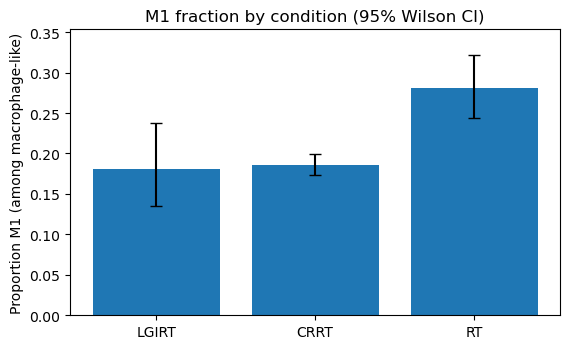

In [59]:
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

order = ["LGIRT","CRRT","RT"]
k = summary.loc[order, "M1_sum"].values.astype(int)
n = summary.loc[order, "M1_total"].values.astype(int)
p = k / n

# Wilson CI
low, high = proportion_confint(k, n, alpha=0.05, method="wilson")
err_low = p - low
err_high = high - p

plt.figure(figsize=(5.8,3.6))
x = np.arange(len(order))
plt.bar(order, p, yerr=[err_low, err_high], capsize=4)
plt.ylabel("Proportion M1 (among macrophage-like)")
plt.title("M1 fraction by condition (95% Wilson CI)")
plt.ylim(0, max(high)*1.1)
plt.tight_layout()
plt.show()


In [60]:
from statsmodels.stats.proportion import proportions_ztest

def ztest(a, b):
    # a/b are tuples (k, n)
    stat, pval = proportions_ztest([a[0], b[0]], [a[1], b[1]], alternative="two-sided")
    return stat, pval

LGIRT_vals = (summary.loc["LGIRT","M1_sum"], summary.loc["LGIRT","M1_total"])
CRRT_vals  = (summary.loc["CRRT","M1_sum"], summary.loc["CRRT","M1_total"])
RT_vals    = (summary.loc["RT","M1_sum"],   summary.loc["RT","M1_total"])

for name, cmp in [("RT vs LGIRT", (RT_vals, LGIRT_vals)),
                  ("RT vs CRRT",  (RT_vals, CRRT_vals)),
                  ("LGIRT vs CRRT", (LGIRT_vals, CRRT_vals))]:
    stat, pval = ztest(cmp[0], cmp[1])
    print(f"{name}: z={stat:.2f}, p={pval:.3e}")


RT vs LGIRT: z=2.86, p=4.272e-03
RT vs CRRT: z=5.05, p=4.435e-07
LGIRT vs CRRT: z=-0.19, p=8.458e-01


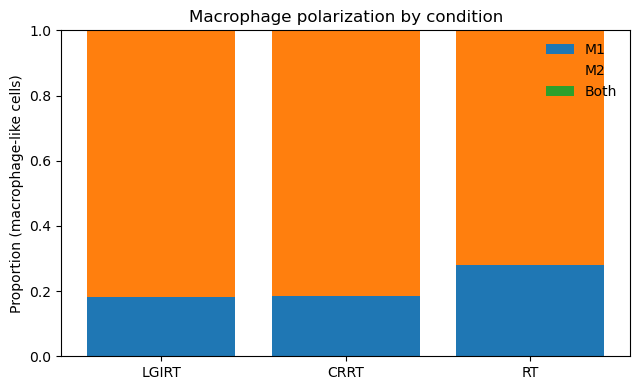

In [61]:
import matplotlib.pyplot as plt
import numpy as np

order = ["LGIRT","CRRT","RT"]
props = props.reindex(order)

plt.figure(figsize=(6.5,4))
bottom = np.zeros(len(props))
for cat in ["M1","M2","Both"]:
    vals = props[cat].values
    plt.bar(props.index, vals, bottom=bottom, label=cat)
    bottom += vals
plt.ylabel("Proportion (macrophage-like cells)")
plt.title("Macrophage polarization by condition")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


M2 – M1 (per condition):
condition
LGIRT    0.638889
CRRT     0.625037
RT       0.436047
dtype: float64


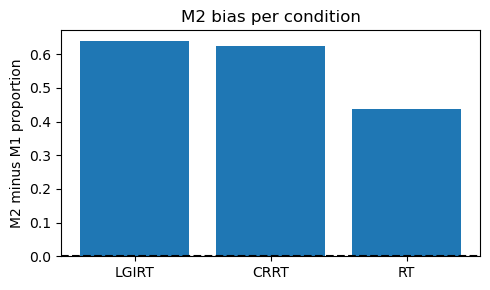

In [62]:
shift = props["M2"] - props["M1"]
print("M2 – M1 (per condition):")
print(shift)

plt.figure(figsize=(5,3))
plt.bar(shift.index, shift.values)
plt.axhline(0, ls="--", c="k")
plt.ylabel("M2 minus M1 proportion")
plt.title("M2 bias per condition")
plt.tight_layout()
plt.show()


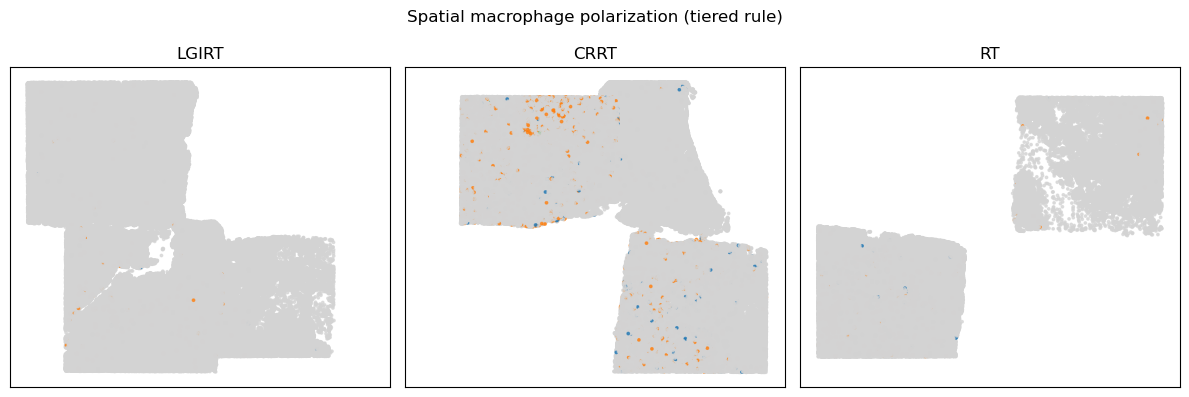

In [63]:
if "spatial" in ST_sample.obsm_keys():
    coords = ST_sample.obsm["spatial"]
    col = ST_sample.obs["Mac_polarization_tiered"]

    fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
    for ax, cond in zip(axes, ["LGIRT","CRRT","RT"]):
        mask = ST_sample.obs["condition"] == cond
        ax.scatter(coords[mask,0], coords[mask,1], s=3,
                   c=col[mask].map({"M1":"tab:blue","M2":"tab:orange",
                                    "Both":"tab:green","Neither":"lightgray"}),
                   alpha=0.7)
        ax.set_title(cond)
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle("Spatial macrophage polarization (tiered rule)")
    plt.tight_layout()
    plt.show()


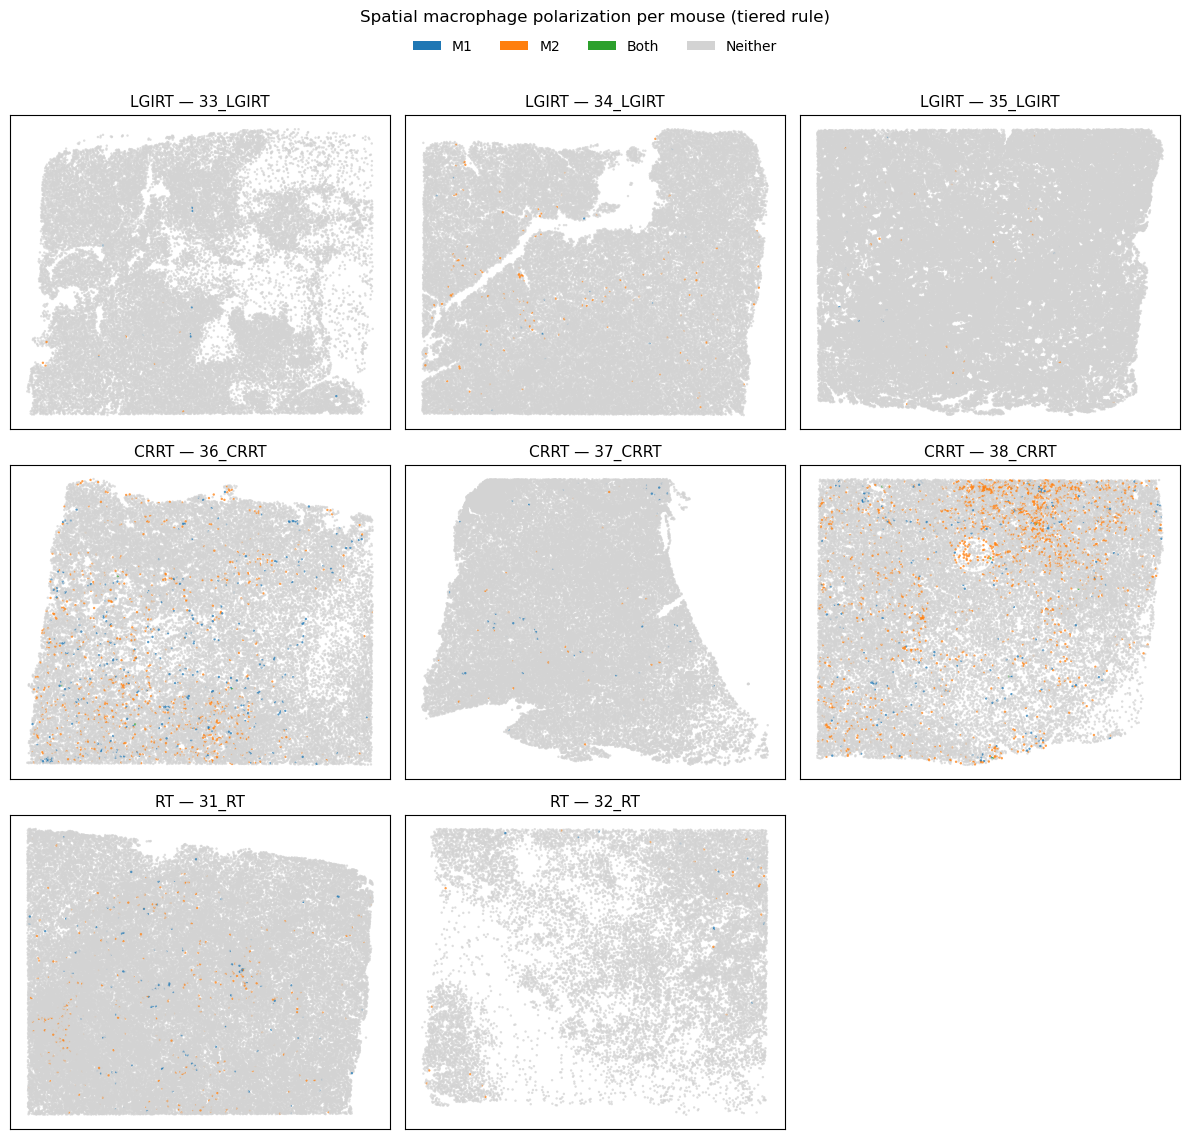

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

assert "spatial" in ST_sample.obsm_keys(), "No ST_sample.obsm['spatial'] found."
coords = ST_sample.obsm["spatial"]
pol    = ST_sample.obs["Mac_polarization_tiered"]
conds  = ST_sample.obs["condition"]
mice   = ST_sample.obs["mouse"]  # must exist

order_cond = ["LGIRT","CRRT","RT"]
color_map = {"M1":"tab:blue","M2":"tab:orange","Both":"tab:green","Neither":"lightgray"}

# collect mice per condition (deterministic order)
mice_per_cond = {c: sorted(ST_sample.obs.loc[conds==c, "mouse"].unique().tolist())
                 for c in order_cond}

# number of columns = max # mice across the three rows
ncols = max(len(v) for v in mice_per_cond.values())
nrows = len(order_cond)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.8*nrows), sharex=False, sharey=False)

# axes always 2D for easy indexing
if nrows == 1:
    axes = np.array([axes])
if ncols == 1:
    axes = axes.reshape(nrows, 1)

for r, cond in enumerate(order_cond):
    row_mice = mice_per_cond[cond]
    for c in range(ncols):
        ax = axes[r, c]
        if c < len(row_mice):
            m = row_mice[c]
            mask = (conds==cond).values & (mice==m).values
            if mask.sum() == 0:
                ax.axis("off")
                continue

            # scatter
            ax.scatter(coords[mask,0], coords[mask,1], s=3,
                       c=pol[mask].map(color_map).values, alpha=0.75, linewidths=0)

            ax.set_title(f"{cond} — {m}", fontsize=11)
            ax.invert_yaxis()
            ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(True)
        else:
            ax.axis("off")

# legend
from matplotlib.patches import Patch
handles = [Patch(facecolor=color_map[k], edgecolor='none', label=k) 
           for k in ["M1","M2","Both","Neither"]]
fig.legend(handles=handles, loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.98))

plt.suptitle("Spatial macrophage polarization per mouse (tiered rule)", y=0.995)
plt.tight_layout(rect=[0,0,1,0.96])  # leave space for legend
plt.show()
